Final Project: Neutron Diffusion

FTCS 2D Neutron Diffusion

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def normal(x,y,sigma):
    """Helper funciton that returns a 2D normal distribution evaluated at x,y"""
    return (np.exp(-(x*x+y*y)/(2*sigma*sigma)))/(sigma*np.sqrt(2*np.pi))

#physical constants
C = 1
D = 1
#lattice size constants
N=50
Nx=N
Ny=N

L=10

Tmax=15


#boundary condition type
boundType=0 #0 for value, 1 for derivative
schemeType=1 # 0 for FTCS, 1 for LAX



if schemeType == 0:
    schemeName="FTCS"
elif schemeType ==1:
    schemeName="LAX"

if boundType ==0:
    boundName = "Boundaries: $n(x,y,t) = 0$"
elif boundType ==1:
    boundName= "Boundaries: $\\frac{\partial n(x,y,t)}{\partial x, y} = 0$"


#Value based boundary conditions
if boundType == 0:
    x_ind=np.arange(Nx+2)# vector of 0 to Nx inclusive
    y_ind=np.arange(Ny+2)#vector of 0 to Nx inclusive
    hx=L/(Nx+1)
    hy=L/(Ny+1)
    x=-L/2 + x_ind*hx
    y=-L/2 + y_ind*hy
    boundval=0



# Derivative-based boundary conditions
if boundType == 1:
    x_ind=np.arange(Nx+2)# vector of 0 to Nx+1 inclusive
    y_ind=np.arange(Ny+2)#vector of 0 to Nx+1 inclusive
    hx=L/Nx
    hy=L/Ny
    x= -L/2 +(x_ind-1/2)*hx
    y= -L/2 +(y_ind-1/2)*hy
    #the value for the derivative on the boundaries is set to zero


#numerical scheme constants
tau = 0.01
if schemeType == 0:
    stabletau= hx*hy/(2*D)
    
elif schemeType ==1:
    stabletau=hx*hy/(2*D)
    #this is not the correct stability tau for LAX

if tau > stabletau:
    tau = stabletau*0.5
max_timestep=int(np.ceil(Tmax/tau))

# iterate 1 to Nx when loopin

grid=np.zeros((Nx+2,Ny+2))


Cgrid=np.ones((Nx+2,Ny+2))*C

#set up grid initial conditions
xp, yp = np.meshgrid(x, y)
grid=normal(xp,yp,1)

evolution=np.zeros((Nx+2,Ny+2,max_timestep))
evolution[:,:,0]=grid
if boundType ==0:
    grid[:,0]=boundval
    grid[:,-1]=boundval
    grid[0,:]=boundval
    grid[-1,:]=boundval
if boundType ==1:
    grid[:,0]=grid[:,1]
    grid[:,-1]=grid[:,-2]
    grid[0,:]=grid[1,:]
    grid[-1,:]=grid[-2,:]
    #the value for the derivative on the boundaries is set to zero
    evolution[:,:,0]=grid


for timestep in range(1,max_timestep):
 #update boundary values for record

    if schemeType == 0:
        #FTCS step
        grid[1:-1,1:-1]=grid[1:-1,1:-1]+D*tau*((grid[2:,1:-1]+grid[0:-2,1:-1]-2*grid[1:-1,1:-1])/(hx*hx)+(grid[1:-1,2:]+grid[1:-1,0:-2]-2*grid[1:-1,1:-1])/(hy*hy))+Cgrid[1:-1,1:-1]*tau*grid[1:-1,1:-1]
    elif schemeType == 1:
        laxavg=(grid[2:,1:-1]+grid[0:-2,1:-1]+grid[1:-1,2:]+grid[1:-1,0:-2])/4
        grid[1:-1,1:-1]=laxavg+D*tau*((grid[2:,1:-1]+grid[0:-2,1:-1]-2*laxavg)/(hx*hx)+(grid[1:-1,2:]+grid[1:-1,0:-2]-2*laxavg)/(hy*hy))+Cgrid[1:-1,1:-1]*tau*laxavg
        #lax step
    if boundType ==1:
        grid[:,0]=grid[:,1]
        grid[:,-1]=grid[:,-2]
        grid[0,:]=grid[1,:]
        grid[-1,:]=grid[-2,:]
        #the value for the derivative on the boundaries is set to zero
        #seems to be assigning by value rather than reference, which is good as by reference would break everything

    # by changing from a double loop over coordinates to an all-at-once matrix indexed option, a run went from 15.8 seconds to 0.266s
    # this was a transformation of i -> 1:-1, i+1 - > 2:, i-1 -> 0:-2
    #and the same for j
    evolution[:,:,timestep]=np.ndarray.copy(grid)

t= np.arange(max_timestep)*tau#create time indexing variable


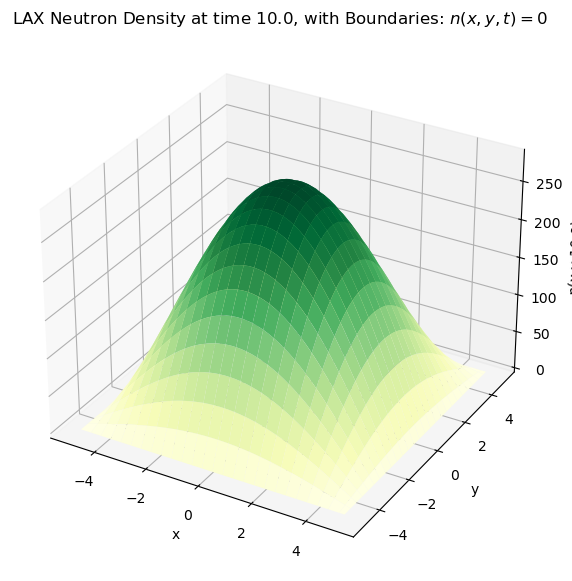

In [16]:
t_slice_index=1000

timeslice=t[t_slice_index]
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
xp, yp = np.meshgrid(x, y)

ax.plot_surface(xp, yp, evolution[:,:,t_slice_index], rstride=2, cstride=2, cmap='YlGn')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(f'n(x,y,{timeslice})')
plotitle=f'{schemeName} Neutron Density at time {timeslice}, with {boundName}'
ignore=ax.set_title(plotitle)
#ignore variable captures output that would otherwise get in the way

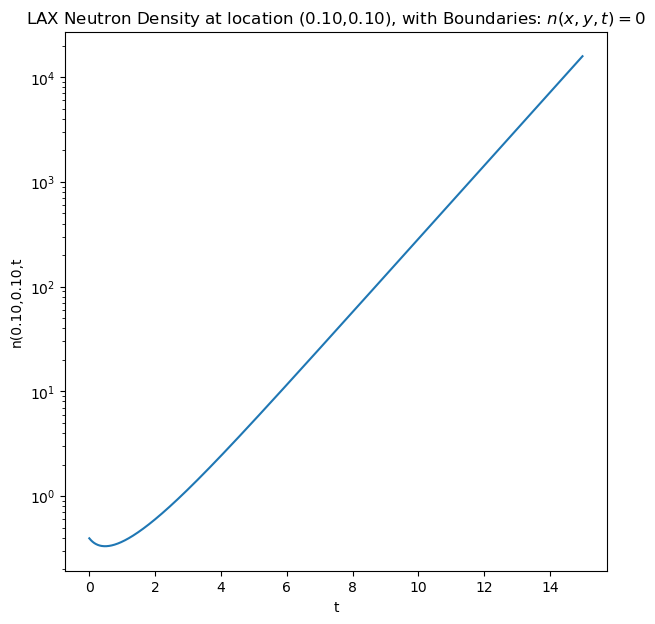

In [17]:
approx_center_index_x=int(np.ceil((Nx+2)/2))
approx_center_index_y=int(np.ceil((Ny+2)/2))

samplex=26
sampley=26

xval=x[samplex]
yval=y[sampley]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.semilogy(t,evolution[samplex,sampley,:])

ax.set_xlabel('t')
ax.set_ylabel(f'n({xval:.2f},{yval:.2f},t')
plotitle=f'{schemeName} Neutron Density at location ({xval:.2f},{yval:.2f}), with {boundName}'
ignore=ax.set_title(plotitle)

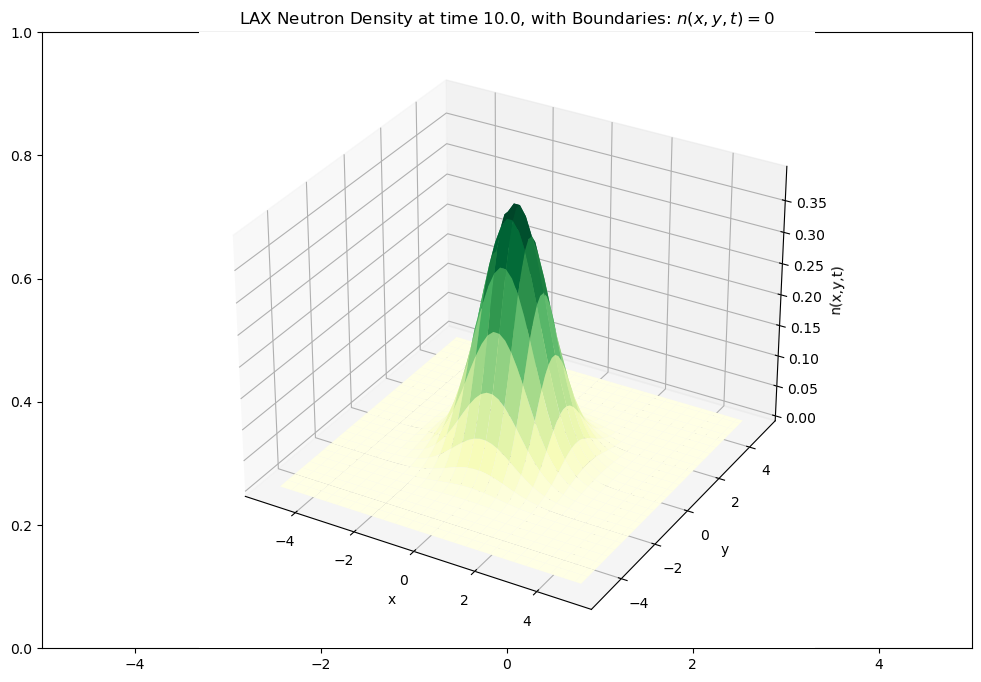

In [18]:
import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(12,8))
ax.set(xlim=(-L/2,L/2))
ax = fig.add_subplot(projection='3d')

xp, yp = np.meshgrid(x, y)
curve=ax.plot_surface(xp, yp, evolution[:,:,0], rstride=2, cstride=2, cmap='YlGn')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(f'n(x,y,t)')

plotitle=f'{schemeName} Neutron Density at time {timeslice}, with {boundName}'
plt.title(plotitle)
#ignore variable captures output that would otherwise get in the way

stop_frame=10000000
actual_stop_frame=min(stop_frame,max_timestep)

def animateDiffusion(i):
    """ Helper function that sets the curve at a given frame i so that it can be rendered to video"""
    ax.clear()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel(f'n(x,y,t)')
    curve=ax.plot_surface(xp, yp, evolution[:,:,i], rstride=2, cstride=2, cmap='YlGn')
    plt.title(f'{schemeName} Neutron Density at time {t[i]:.2f}, with {boundName}')
    if i % np.ceil(actual_stop_frame/100) == 0:
        print(f'{i/(actual_stop_frame)*100:.1f} % done')

    return curve


save_anim = False


if save_anim:
    anim=animation.FuncAnimation(fig,animateDiffusion,interval=1000*tau,frames=actual_stop_frame)
    anim.save(f'neutrons_C={C}_D={D}_t={tau}_T={max_timestep}_hx={hx}_L={L}_{schemeName}_bound={boundType}.mp4')

Compare to analytical solution of sines ina box for value=0 boundary conditions

Text(0.5, 1.0, 'Comparison of Solutions')

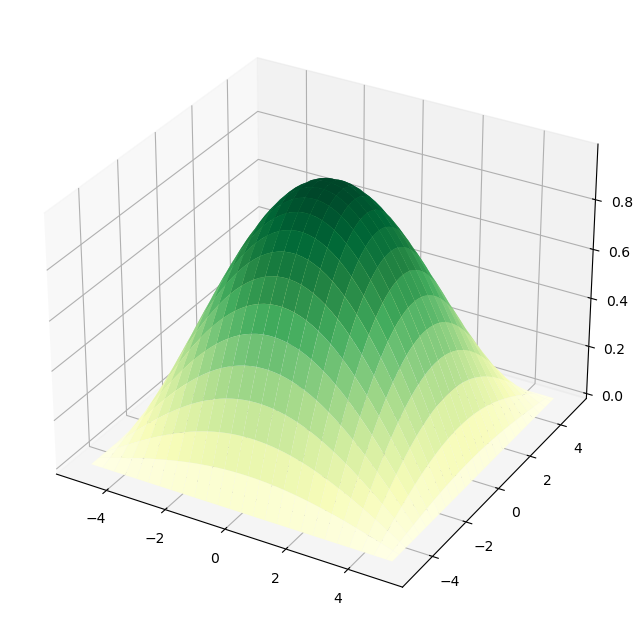

<Figure size 640x480 with 0 Axes>

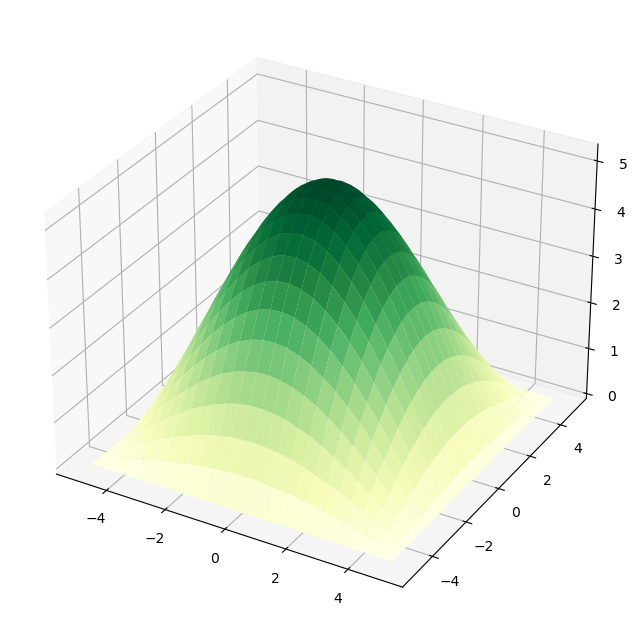

<Figure size 640x480 with 0 Axes>

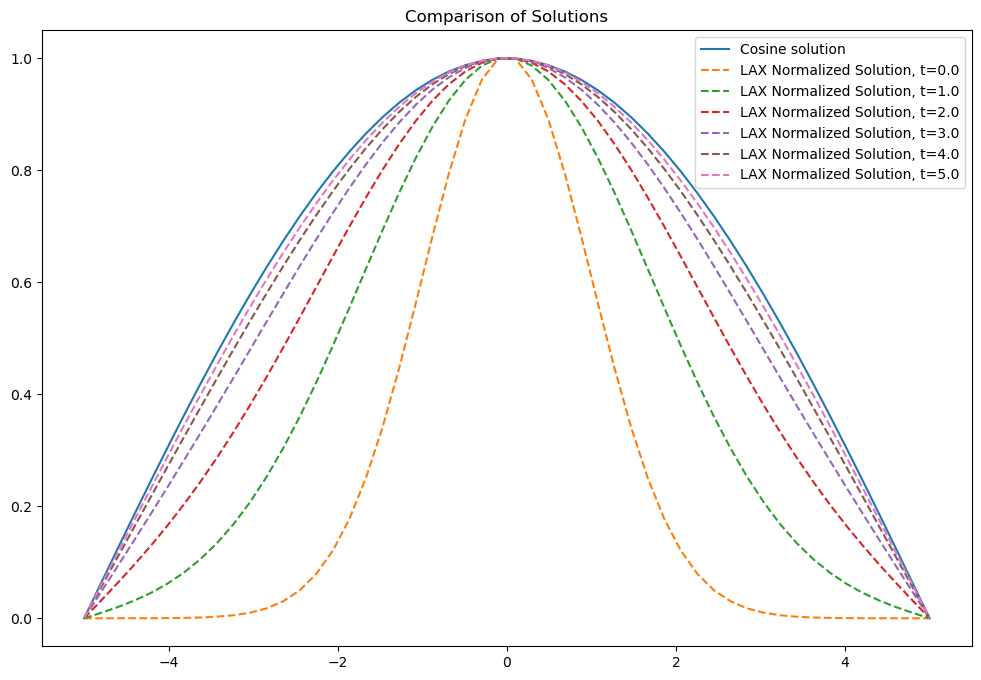

In [50]:
def analytic_soln(x,y):
    A=np.cos(np.pi/L*x)*np.cos(np.pi/L*y)
    return A


xp, yp = np.meshgrid(x, y)
solut=analytic_soln(xp,yp)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')
plt.figure()
curve_soln=ax.plot_surface(xp, yp, solut, rstride=2, cstride=2, cmap='YlGn')


fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')
plt.figure()
curve_exper=ax.plot_surface(xp, yp, evolution[:,:,500], rstride=2, cstride=2, cmap='YlGn')



fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
curve_soln2=ax.plot(x,solut[:,(Ny+2)//2],label='Cosine solution')


timestep_of_graph=500
for graphtime in range(6):
    timestep_of_graph=graphtime*100
    norm_factor=np.max(evolution[:,(Ny+2)//2,timestep_of_graph])
    curve_exper2=ax.plot(x,evolution[:,(Ny+2)//2,timestep_of_graph]/norm_factor,label=f'{schemeName} Normalized Solution, t={t[timestep_of_graph]}',linestyle='--')

plt.legend()
plt.title(f'Comparison of Solutions')


Thank god this thing DOES look like what I expect for the analytical solution.

This thing devolves into the lowest frequency oscillation that fits in the box, which makes sense as in forier space hte diffusion equation amplifies the lowest frequency components and squelches the high frequency components, as expected. The initial gaussian was gaussian in both frequency and real space in both dimensions, so along each dimension it had all the frequencies slowly culled by the diffusion behavior of the neutrons. Only the lowest frequency allowed remains, as the diffusion equation can't make the frequency go lower with the boundary condition of $\rho = 0$. The amplification behavior only adds an $e^{\alpha t}$ out front of the equation.

Curve fit some of the n(t) to exponential curves, maybe show on semilogy chart

In [27]:
asas=(Ny+2)//2

In [28]:
del bleh
bleh = np.ones(26)
fafaf=bleh[asas]

IndexError: index 26 is out of bounds for axis 0 with size 26